In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import OLSInfluence

In [82]:
# Chargement des données
file_path = 'data.csv'
data = pd.read_csv(file_path)

In [83]:
# Nettoyage des données : suppression des doublons et des valeurs manquantes
data = data.drop_duplicates().dropna()

In [84]:
# Division des données en variables indépendantes (X) et dépendante (y)
X = data.drop('charges', axis=1)
y = data['charges']

In [85]:
# Prétraitement et transformation des données
def preprocess_data(X):
    # Création d'une colonne binaire pour les fumeurs
    X['smoker_binary'] = (X['smoker'] == 'yes').astype(int)

    # Catégorisation du BMI
    bins = [0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')]
    labels = ['underweight', 'normal weight', 'overweight', 'obesity class I', 'obesity class II', 'obesity class III']
    X['BMI_category'] = pd.cut(X['bmi'], bins=bins, labels=labels, right=False)

    # Retrait des colonnes non nécessaires
    X = X.drop(['smoker', 'BMI_category'], axis=1)

    return X

X = preprocess_data(X)

In [86]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=42, shuffle=True)

# Configuration des pipelines de prétraitement
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

numerical_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder()),
    ('poly', PolynomialFeatures(degree=2))
])

preprocessor = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, numerical_cols),
    ('categorical', categorical_pipeline, categorical_cols)
])

# Appliquez le prétraitement aux ensembles d'entraînement et de test
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Utiliser statsmodels pour la régression et la distance de Cook
X_train_transformed_sm = sm.add_constant(X_train_transformed)
model_sm = sm.OLS(y_train, X_train_transformed_sm).fit()
influence = model_sm.get_influence()
cooks_d = influence.cooks_distance[0]

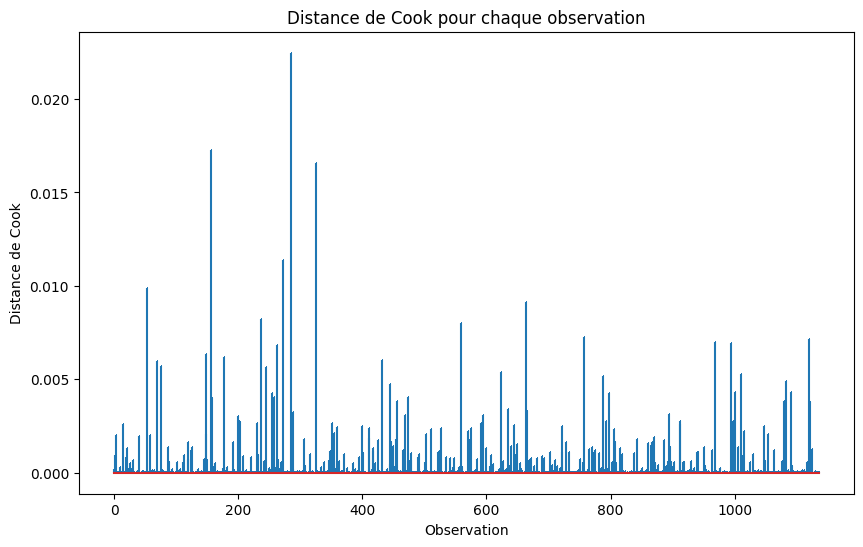

In [92]:
# Création d'un graphique pour visualiser la distance de Cook
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.title('Distance de Cook pour chaque observation')
plt.xlabel('Observation')
plt.ylabel('Distance de Cook')
plt.show()

In [87]:
# Seuil pour la distance de Cook (à ajuster selon vos besoins)
threshold_cooks = 4 / len(X_train)
mask = cooks_d < threshold_cooks

X_train_filtered = X_train[mask]
y_train_filtered = y_train[mask]

In [88]:
# Construction des pipelines pour différents modèles
LR_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regression', LinearRegression())
])

Lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('Lasso', Lasso())
])

ElasticNet_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ElasticNet', ElasticNet())
])


In [89]:
# Entraînement et évaluation des modèles
pipelines = [LR_pipeline, Lasso_pipeline, ElasticNet_pipeline]
for pipeline in pipelines:
    pipeline.fit(X_train_filtered, y_train_filtered)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"{pipeline.steps[-1][0]}: MSE={mse}, R2={r2}, RMSE={rmse}")


regression: MSE=21483708.037324164, R2=0.8792263136643451, RMSE=4635.052107293312
Lasso: MSE=21463237.182132702, R2=0.8793413934559537, RMSE=4632.843315085532
ElasticNet: MSE=36195856.81530571, R2=0.796519900099774, RMSE=6016.299262445787


/home/antoine/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.078e+09, tolerance: 1.443e+07
  model = cd_fast.enet_coordinate_descent(


In [90]:
# Recherche des meilleurs paramètres pour ElasticNet
param_grid = {
    'ElasticNet__alpha': np.linspace(1e-3, 1, 30),
    'ElasticNet__l1_ratio': np.linspace(0.01, 1, 30)
}

grid = GridSearchCV(ElasticNet_pipeline, param_grid, cv=5)
grid.fit(X_train_filtered, y_train_filtered)
print(f"Meilleurs paramètres ElasticNet: {grid.best_params_}")


/home/antoine/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.934e+09, tolerance: 1.114e+07
  model = cd_fast.enet_coordinate_descent(
/home/antoine/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.957e+09, tolerance: 1.157e+07
  model = cd_fast.enet_coordinate_descent(
/home/antoine/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Meilleurs paramètres ElasticNet: {'ElasticNet__alpha': 1.0, 'ElasticNet__l1_ratio': 1.0}


/home/antoine/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.078e+09, tolerance: 1.443e+07
  model = cd_fast.enet_coordinate_descent(


In [91]:
# Évaluation du modèle ElasticNet optimisé
best_model = grid.best_estimator_
print(f"Score du modèle ElasticNet optimisé: {best_model.score(X_test, y_test)}")

Score du modèle ElasticNet optimisé: 0.8793413934559537
